In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 21 20:43:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!pip install sentencepiece
!pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.8 MB/s 
     |████████████████████████████████| 431 kB 79.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 120 kB 98.3 MB/s 
     |████████████████████████████████| 115 kB 92.8 MB/s 
     |████████████████████████████████| 212 kB 76.9 MB/s 
     |████████████████████████████████| 127 kB 86.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [10]:
!apt install git-lfs
!git config --global user.email "ikerherrero21@gmail.com"
!git config --global user.name "Iker Herrero"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [11]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, ClassLabel, load_metric
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [12]:
def evaluate(pipeline, dataset_test, labels, output_dict=False):
    y_hat_proba = pipeline.predict(dataset_test)
    y_hat = np.argmax(y_hat_proba[0], axis=1)
    return classification_report(labels, y_hat, output_dict=output_dict)

In [13]:
def compute_metrics(eval_pred):
    metric = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='micro')

In [14]:
#Importar drive para guardar modelo o importar datos
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
PATH ="/content/gdrive/MyDrive/Colab Notebooks/TFM/dataSet/raw_data_verbos.csv"
try:
    dataSet = pd.read_csv(PATH,sep=";", encoding='latin1',error_bad_lines=False)
except:
    print("error")
numClass = len(dataSet['Dialecto'].unique())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
dataSet.head()

,Frase,Dialecto,Lugar,Verbo
0,urazan bare bat aurkitu zuelako nazka-aurpegia...,Nafar-Lapurtarra,Ahetze,True
1,urazan bare bat aurkitu zuelako nazka-aurpegia...,Erdialdekoa,Aia,True
2,urazan baresitsa bat aurkitu zuelako nazka-aur...,Erdialdekoa,Aia,True
3,urazan bare bat aurkitu zuelako nazka-aurpegia...,Nafar-Lapurtarra,Aldude,True
4,urazan bare bat aurkitu zuelako nazka-aurpegia...,Nafarra,Alkotz,True


In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [18]:
!git config --global credential.helper store

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MODEL_NAME = "ixa-ehu/roberta-eus-cc100-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                               num_labels=numClass).to(device)

Downloading:   0%|          | 0.00/351 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/238 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/652M [00:00<?, ?B/s]

Some weights of the model checkpoint at ixa-ehu/roberta-eus-cc100-base-cased were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ixa-ehu/roberta-eus-cc100-base-cased and are newly initialized: ['classifier.dense.weight'

In [20]:
import matplotlib.pyplot as plt

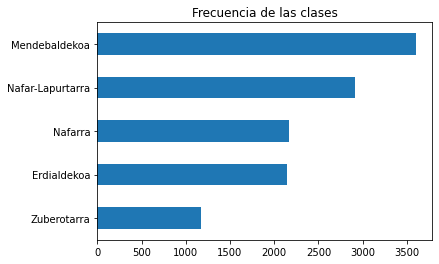

In [21]:
dataSet['Dialecto'].value_counts(ascending =True).plot.barh()
plt.title('Frecuencia de las clases')
plt.show()

In [22]:
N_SAMPLES = 70
data = pd.DataFrame()
#data = dataSet.groupby('Dialecto', group_keys=False).apply(lambda x: x.sample(N_SAMPLES))
data[['text', 'label']] = dataSet[['Frase', 'Dialecto']]
#data = data.drop(columns=['Frase', 'Dialecto'], axis=1)
list_labels = data.label.unique().tolist()
features = ClassLabel(names=list_labels)
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data.label, shuffle=True,random_state = 1)
label4,label0,label2,label1,label3 = data_train['label'].value_counts()
arrayLabels = np.array([label0, label1, label2, label3, label4])
maxLabels =np.amax(arrayLabels)
indiceLabel0 = round(maxLabels/label0,2)
indiceLabel1 = round(maxLabels/label1,2)
indiceLabel2 = round(maxLabels/label2,2)
indiceLabel3 = round(maxLabels/label3,2)
indiceLabel4 = round(maxLabels/label4,2)
print(list_labels)
print(data_train['label'].value_counts())
print(indiceLabel0,indiceLabel1,indiceLabel2,indiceLabel3,indiceLabel4)

['Nafar-Lapurtarra', 'Erdialdekoa', 'Nafarra', 'Zuberotarra', 'Mendebaldekoa']
Mendebaldekoa       2885
Nafar-Lapurtarra    2334
Nafarra             1732
Erdialdekoa         1718
Zuberotarra          942
Name: label, dtype: int64
1.24 1.68 1.67 3.06 1.0


In [23]:
datasetTrain = Dataset.from_pandas(data_train)
datasetTest = Dataset.from_pandas(data_test)

In [24]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], padding=True, truncation=True, max_length=512)
    tokens['label'] = features.str2int(batch['label'])
    return tokens

In [25]:
datasetTrain = datasetTrain.map(tokenize, batched=True)
datasetTest = datasetTest.map(tokenize, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [26]:
training_args = TrainingArguments(#output_dir="/content/gdrive/MyDrive/Colab Notebooks/TFM/modelHF_dialect",
                                      output_dir="results",
                                      overwrite_output_dir=True,
                                      num_train_epochs=5,#5
                                      per_device_train_batch_size=1,
                                      evaluation_strategy="epoch",
                                      learning_rate=7.2193610624691235e-06,
                                      warmup_steps=0.7,
                                      weight_decay=0.04607216467251203,
                                      save_total_limit=1,
                                      save_strategy='no'
                                      )

In [27]:
from torch import nn
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 5 labels with different weights)
        #loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([np.float32(indiceLabel0), np.float32(indiceLabel1), np.float32(indiceLabel2),np.float32(indiceLabel3),np.float32(indiceLabel4)])).to(device)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([np.float32(1), np.float32(1), np.float32(1),np.float32(1),np.float32(1)])).to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [28]:
trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=datasetTrain,
        eval_dataset=datasetTest,
        compute_metrics=compute_metrics,
    )

In [29]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9611
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 48055


Epoch,Training Loss,Validation Loss,F1
1,1.440900,1.394774,0.578027
2,1.418700,1.363472,0.632959
3,1.046200,1.275623,0.665834
4,1.364200,1.430547,0.667499
5,1.115900,1.370491,0.687474


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2403
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2403
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2403
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `RobertaForSequenceClassification.f

TrainOutput(global_step=48055, training_loss=1.2872469861454576, metrics={'train_runtime': 2918.7528, 'train_samples_per_second': 16.464, 'train_steps_per_second': 16.464, 'total_flos': 489772324383990.0, 'train_loss': 1.2872469861454576, 'epoch': 5.0})

In [30]:
#trainer.push_to_hub()

In [31]:
prediction = trainer.predict(pruebaTest)
report = evaluate(trainer, pruebaTest, pruebaTest['label'])
print(report)

NameError: ignored

In [ ]:
prediction.metrics

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False,xticks_rotation='vertical')
  plt.title('Normalized confusion matrix')
  plt.show()

In [ ]:
y_preds = np.argmax(prediction.predictions, axis=1)
plot_confusion_matrix(y_preds, pruebaTest['label'], list_labels)

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device),reduction='none')
  return {'loss':loss.cpu().numpy(),
        'predicted_label':pred_label.cpu().numpy()}

In [ ]:
#Convert our dataset back to PyTorch tensors
datasetTest.set_format('torch',
                       columns=['input_ids','attention_mask','label'])

In [ ]:

#Compute loss values
datasetTest = datasetTest.map(forward_pass_with_label,batched=True,batch_size=4)

In [ ]:
datasetTest.set_format('pandas')
cols =['text','label','predicted_label','loss']
df_test = datasetTest[:][cols]
df_test['label'] = features.str2int(df_test['label'])
df_test['predicted_label'] = features.str2int(df_test['predicted_label'])

In [ ]:
df_test.sort_values('loss',ascending=False).head(20)